In [23]:
suppressMessages(library(rwwa))
png_res <- 240

# Exploratory analysis

In [24]:
cov_df <- merge(read.table("ts-obs/gmst.dat", col.names = c("year", "gmst")),
                load_ts("ts-obs/med-storms_nao-djf_era5-stn.dat", col.names = c("year", "nao")))
cov_df$gmst <- cov_df$gmst - cov_df$gmst[cov_df$year == 2026]
cov_df$nao_res <- resid(lm(nao ~ gmst, cov_df))

cov_2026 <- cov_df[cov_df$year == 2026,c(-1),drop = F]
cov_cf <- rbind("pi" = cov_2026 - c(1.3,0,0),
                "naoneutral" = c(cov_2026$gmst, 0,0),
                "pineutral" = c(-1.3, 0,0))

In [46]:
rnm <- "s"
varnm <- "rx1day-ondjfm"

df_list <- sapply(list.files("ts-obs", pattern = paste0(varnm,"_",rnm), full.names = T), 
       function(fnm) load_ts(fnm, col.names = c("year", gsub(".dat|.+_","",fnm))), simplify = F)

ts_df <- Reduce(function(df1, df2) merge(df1, df2, by = "year", all.x = TRUE, all.y = TRUE), df_list)
df <- merge(cov_df, ts_df, all.x = T)

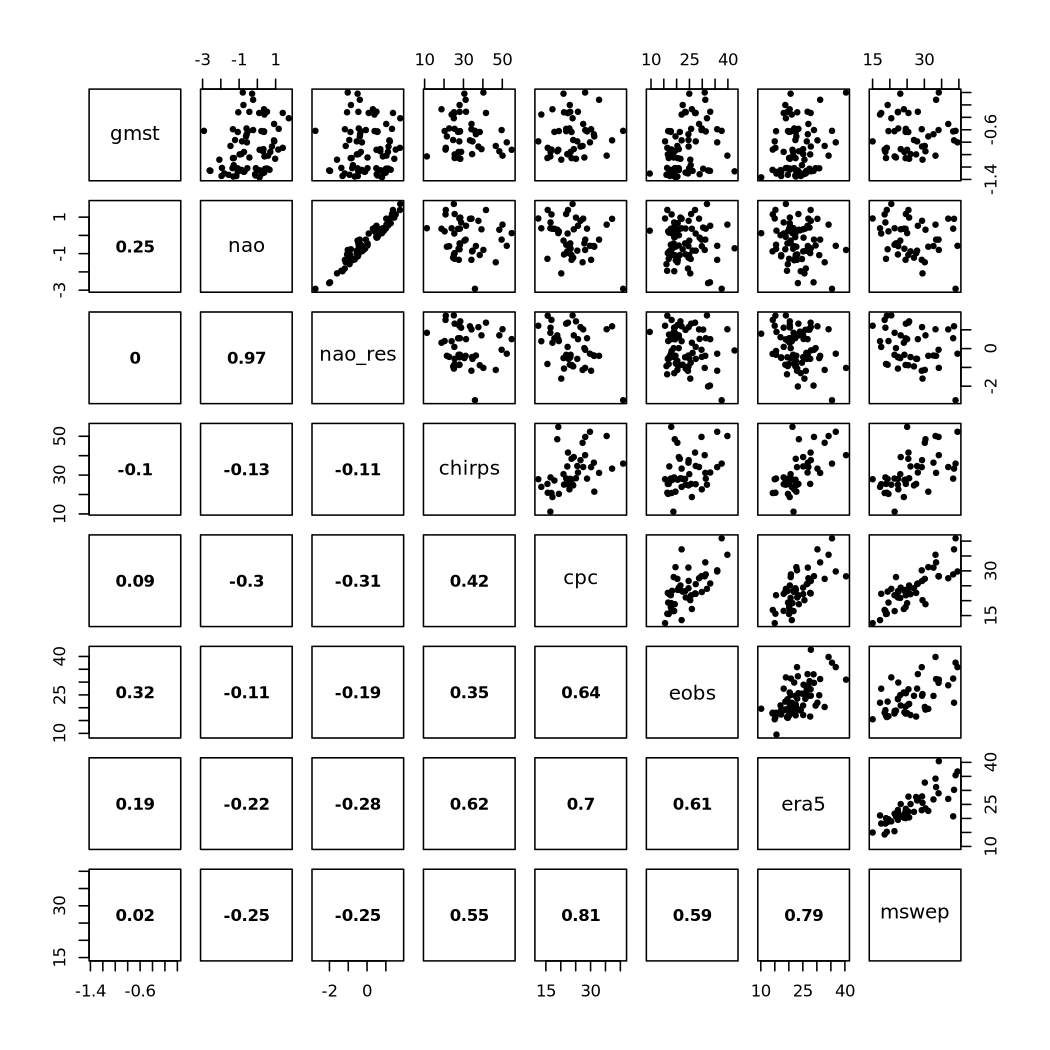

In [47]:
prep_window(res = 150, h = 7, w = 7)
pairs(df[,-1], lower.panel = panel.cor)

## Check distribution

In [48]:
png(paste0("fig/expl_distribution_",varnm,"_",rnm,".png"), h = png_res, w = png_res*5); {
    prep_window(c(1,5), res = 150, oma = c(0,0,3,0))

    for (i in 1:5) {
        ds_nm <- c("chirps","cpc","eobs","era5","mswep")[i]
        df_c <- df[,ds_nm, drop = F]
        df_c <- df_c[!is.na(df_c)]
        if (varnm == "rx90day") {
            df_c <- log(df_c)
            suptitle <- paste0("log rx90day (",rnm,")")
        } else {
            suptitle <- paste0("rx1day-ondjfm (",rnm,")")
        }
        
        plot(density(df_c, na.rm = T), lwd = 2, main = ds_nm)
        lines(x <- seq(-1,120,0.01), do.call(devd, append(setNames(as.list(fevd(df_c)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue", lwd = 2)
        lines(x, dnorm(x, mean(df_c), sd(df_c)), col = "red3", lwd = 2)
        legend("topleft", c("Obs", "GEV", "normal"), col = c("black", "blue", "red3"),lty = 1, lwd = 2)
    }
    mtext(suptitle, outer = T, side = 3, font = 2)
    
}; dev.off()

agg_record_56696551 
                  2

## Covariate selection

In [6]:
mdl_gmst_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "gmst", varnm = cnm, lower = F)
}, simplify = F)

mdl_gmstnaores_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = c("gmst", "nao_res"), varnm = cnm, lower = F)
}, simplify = F)

mdl_gmstnao_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = c("gmst", "nao"), varnm = cnm, lower = F)
}, simplify = F)

mdl_gmst_shiftscale <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "shiftscale", df[!is.na(df[,cnm]),], covnm = "gmst", varnm = cnm, lower = F)
}, simplify = F)

In [7]:
# NAO it is.
round(rbind("GMST only" = sapply(mdl_gmst_fixeddisp, aic),
            "GMST + NAO" = sapply(mdl_gmstnao_fixeddisp, aic),
            "GMST + NAO (detrended)" = sapply(mdl_gmstnaores_fixeddisp, aic)), 1)

,chirps,cpc,eobs,era5,mswep
GMST only,341.1,313.1,488.7,482.3,317.5
GMST + NAO,342.3,310.4,487.3,478.3,315.4
GMST + NAO (detrended),342.3,310.4,487.3,478.3,315.4


In [8]:
res <- sapply(list("GMST only" = mdl_gmst_fixeddisp,
                   "GMST + NAO" = mdl_gmstnao_fixeddisp,
                   "GMST + NAO (detrended)" = mdl_gmstnaores_fixeddisp),
              function(mlist) sapply(mlist, mdl_ests, cov_f = cov_2026, cov_cf = cov_cf), simplify = F)

In [9]:
cat("alpha_gmst parameter:")
round(sapply(res, "[", "alpha_gmst",),2)
cat("\n")

cat("% change in intensity (GMST):")
round(sapply(res, "[", "dI_rel_pi",),2)
cat("\n")

cat("% change in intensity (NAO):")
round(sapply(res, "[", "dI_rel_naoneutral",),2)
cat("\n")

cat("% change in intensity (both):")
round(sapply(res, "[", "dI_rel_pineutral",),2)
cat("\n")

cat("Return period:")
round(sapply(res, "[", "return_period",),2)
cat("\n")

alpha_gmst parameter:

,GMST only,GMST + NAO,GMST + NAO (detrended)
chirps,-2.97,-2.68,-3.31
cpc,1.96,2.46,1.22
eobs,7.13,8.18,7.13
era5,2.94,3.77,2.70
mswep,0.11,0.14,-0.99



% change in intensity (GMST):

,GMST only,GMST + NAO,GMST + NAO (detrended)
chirps,-13.95,-12.67,-15.54
cpc,11.87,15.11,7.41
eobs,42.39,49.22,42.36
era5,17.66,23.01,16.27
mswep,0.63,0.81,-5.49



% change in intensity (NAO):

,GMST only,GMST + NAO,GMST + NAO (detrended)
chirps,0,3.38,4.37
cpc,0,6.64,8.64
eobs,0,4.44,5.76
era5,0,5.36,6.95
mswep,0,6.23,8.11



% change in intensity (both):

,GMST only,GMST + NAO,GMST + NAO (detrended)
chirps,-13.95,-9.72,-11.85
cpc,11.87,22.76,16.69
eobs,42.39,55.83,50.56
era5,17.66,29.60,24.35
mswep,0.63,7.09,2.17



Return period:

,GMST only,GMST + NAO,GMST + NAO (detrended)
chirps,9.46,7.59,7.53
cpc,3.35,2.61,2.61
eobs,2.73,2.22,2.23
era5,82.61,39.80,39.88
mswep,9.03,6.76,6.74


In [10]:
round(res[[3]], 1)[c("event_magnitude", "return_period", "PR_pi", "dI_rel_pi", "PR_naoneutral", "dI_rel_naoneutral"),]

,chirps,cpc,eobs,era5,mswep
event_magnitude,40.3,28.2,31.0,40.4,34.2
return_period,7.5,2.6,2.2,39.9,6.7
PR_pi,0.4,1.4,6.4,13.8,0.7
dI_rel_pi,-15.5,7.4,42.4,16.3,-5.5
PR_naoneutral,1.3,1.5,1.2,2.7,1.7
dI_rel_naoneutral,4.4,8.6,5.8,7.0,8.1


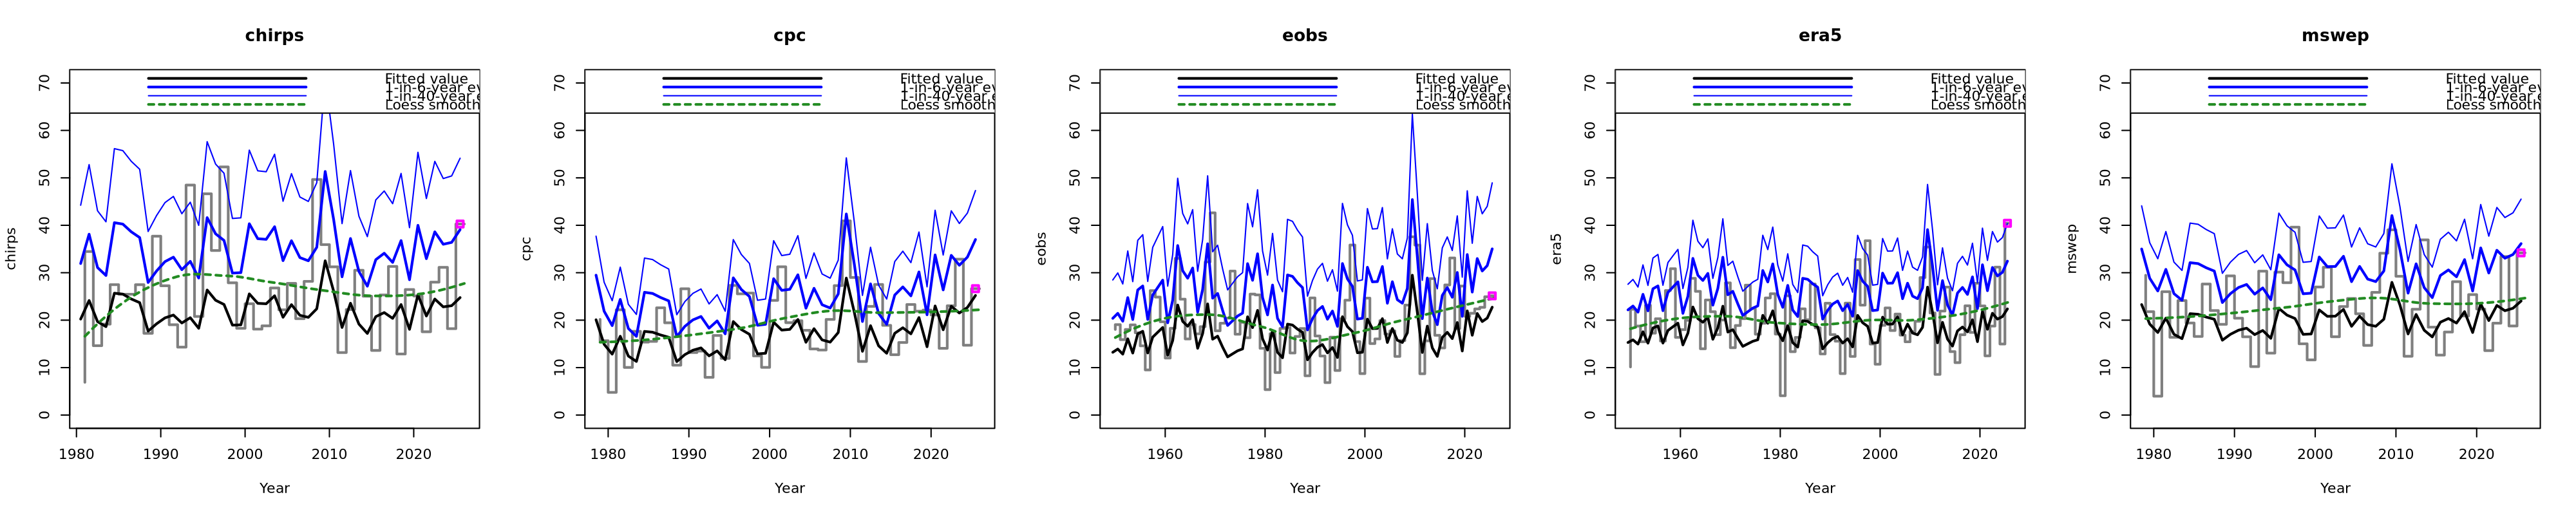

In [32]:
prep_window(c(1,5))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_trend(mdl_gmstnao_fixeddisp[[mnm]], main = mnm, ylim = c(0,70))
# }

for (mnm in names(mdl_gmstnaores_fixeddisp)) {
    plot_trend(mdl_gmstnaores_fixeddisp[[mnm]], main = mnm, ylim = c(0,70))
}

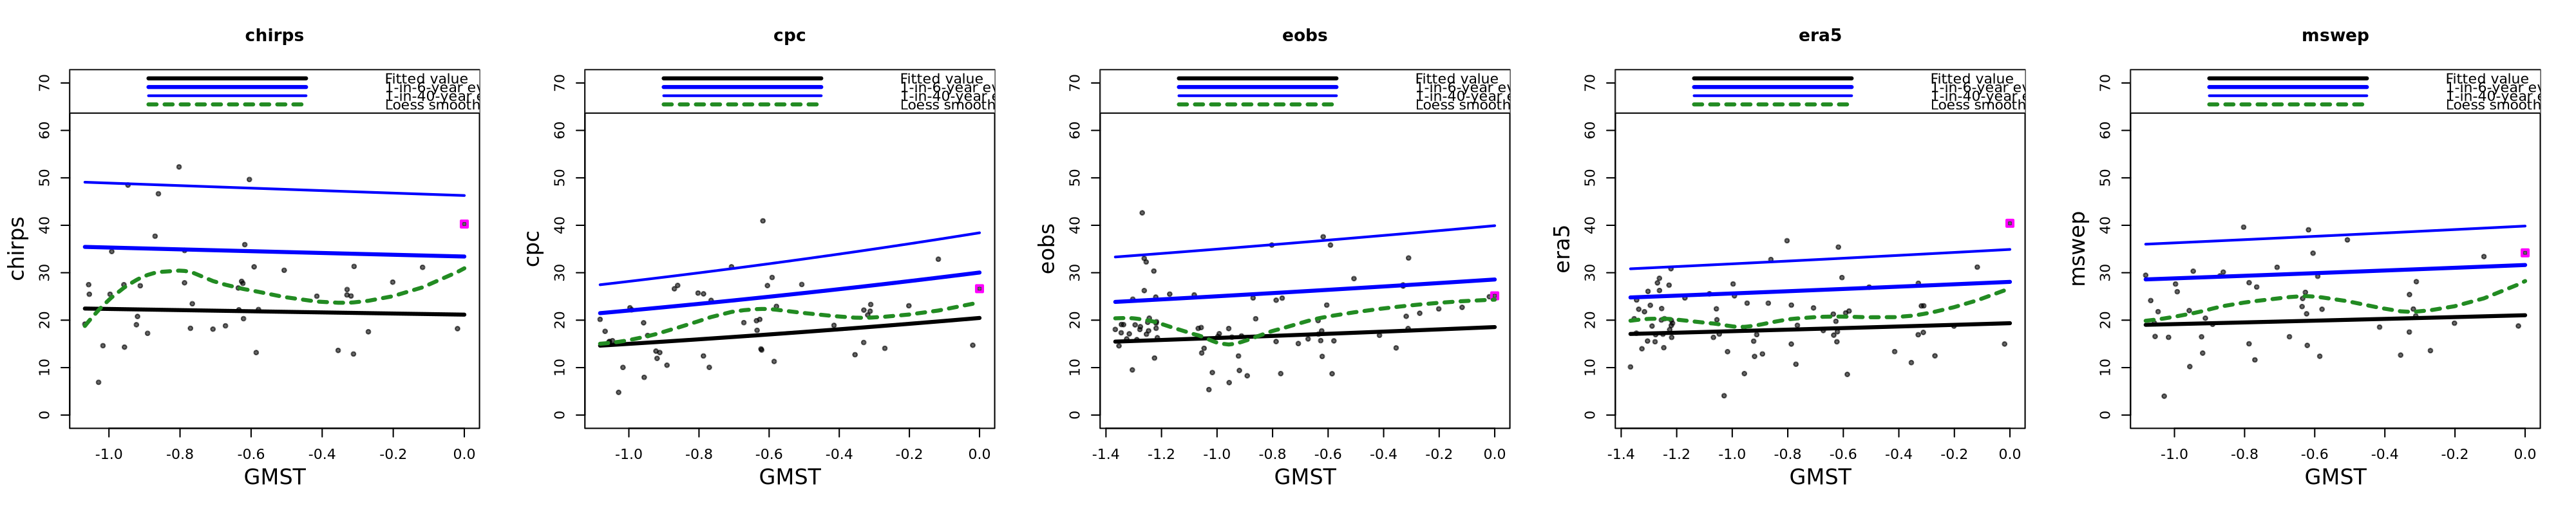

In [34]:
prep_window(c(1,5))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_covtrend(mdl_gmstnao_fixeddisp[[mnm]], "gmst", main = mnm, ylim = c(0,70))
# }
for (mnm in names(mdl_gmstnaores_fixeddisp)) {
    plot_covtrend(mdl_gmstnaores_fixeddisp[[mnm]], "gmst", main = mnm, ylim = c(0,70))
}

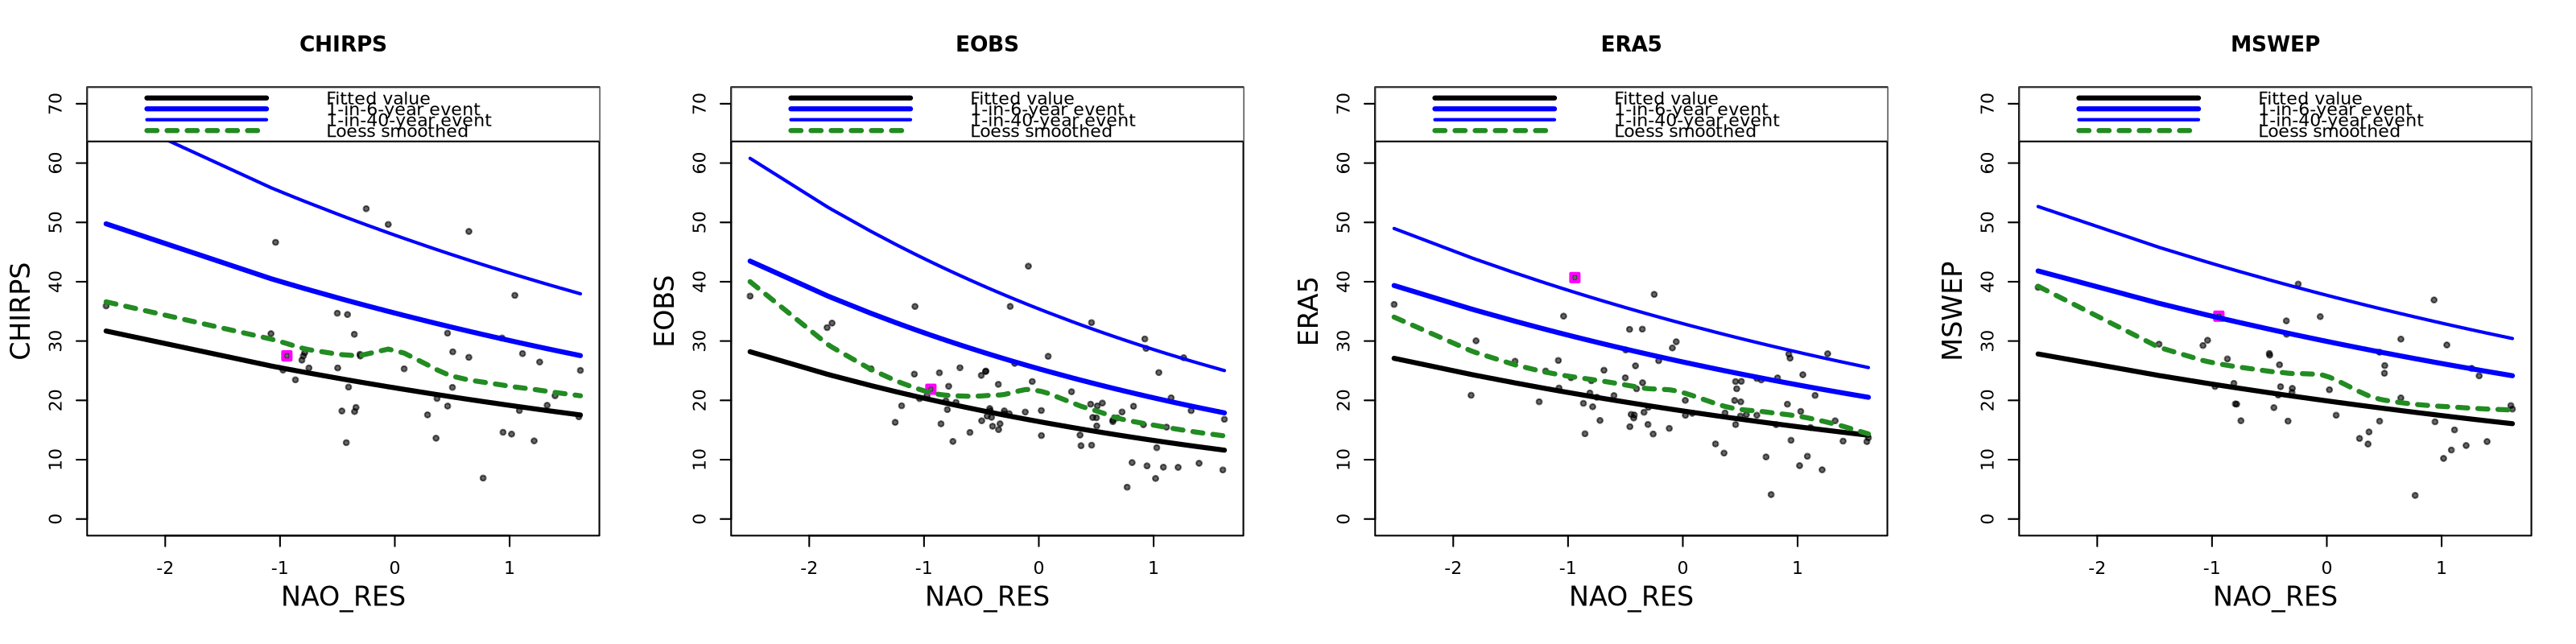

In [127]:
prep_window(c(1,4))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_covtrend(mdl_gmstnao_fixeddisp[[mnm]], "nao", main = mnm, ylim = c(0,70))
# }

for (mnm in names(mdl_gmstnaores_fixeddisp)) {
    plot_covtrend(mdl_gmstnaores_fixeddisp[[mnm]], "nao_res", main = mnm, ylim = c(0,70))
}

## Bootstrap model results

In [ ]:
boot_res <- sapply(mdl_gmst_fixeddisp, boot_ci, cov_f = cov_2026, cov_cf = cov_cf, simplify = F)
sapply(names(boot_res), function(ds_nm) write.csv(boot_res[[ds_nm]], paste0("res/res-obs_rx1day_gmst_",tolower(ds_nm),".csv")))

In [49]:
boot_res <- sapply(mdl_gmstnao_fixeddisp, boot_ci, cov_f = cov_2026, cov_cf = cov_cf, simplify = F)
sapply(names(boot_res), function(ds_nm) write.csv(boot_res[[ds_nm]], paste0("res/res-obs_rx1day_gmst+nao_",tolower(ds_nm),".csv")))

$chirps
NULL

$cpc
NULL

$eobs
NULL

$era5
NULL

$mswep
NULL

In [ ]:
boot_res <- sapply(mdl_gmstnaores_fixeddisp, boot_ci, cov_f = cov_2026, cov_cf = cov_cf, simplify = F)
sapply(names(boot_res), function(ds_nm) write.csv(boot_res[[ds_nm]], paste0("res/res-obs_rx1day_gmst+naores_",tolower(ds_nm),".csv")))

In [37]:
cols <- c("event_magnitude", "return_period", "PR_pi", "dI_rel_pi", "PR_naoneutral", "dI_rel_naoneutral")
t(sapply(cols, function(cnm) {
    apply(signif(t(sapply(boot_res, "[", cnm, )), 3), 1, function(r) {
        paste0(r[1], " (",r[2], ", ", r[3], ")")
    })
}))

,chirps,cpc,eobs,era5,mswep
event_magnitude,"40.3 (40.3, 40.3)","26.6 (26.6, 26.6)","25.1 (25.1, 25.1)","40.4 (40.4, 40.4)","34.2 (34.2, 34.2)"
return_period,"6.86 (2.87, 134)","1.77 (1.19, 4.6)","1.95 (1.45, 3.16)","40.9 (8.49, Inf)","4.51 (1.98, 22.5)"
PR_pi,"0.73 (0.0254, 6.49)","5.34 (0.825, Inf)","1.64 (0.83, 3.35)","6.85 (0.0589, Inf)","2.01 (0.162, Inf)"
dI_rel_pi,"-6.92 (-49.2, 47.7)","49.6 (-4.26, 126)","18.8 (-5.58, 45.7)","12.6 (-19.1, 40.5)","12.9 (-29, 68.8)"
PR_naoneutral,"2.11 (1.35, 5.52)","1.81 (1.22, 4.58)","1.83 (1.29, 2.92)","12.6 (2.48, Inf)","2.06 (1.12, 20)"
dI_rel_naoneutral,"15.3 (4.57, 28.5)","21.6 (7.2, 39.1)","22.6 (10.7, 38)","15.6 (9.1, 24.7)","13.3 (3, 33.7)"


In [156]:
# suddenly remembering that Rsquared only makes sense for normal distribution 
sapply(colnames(df)[-(1:4)], function(cnm) {
    c("gmst" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "gmst", varnm = cnm, lower = F))[1],
      "nao" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "nao", varnm = cnm, lower = F))[1],
      "nao_res" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "nao_res", varnm = cnm, lower = F))[1])
}, simplify = T) * 100

,CHIRPS,EOBS,ERA5,MSWEP
gmst.r2,-17.67049,-16.305580,-13.556169,-11.172434
nao.r2,-6.18776,1.002298,4.692296,3.448237
nao_res.r2,-7.84274,5.804816,9.068975,5.625477
